# 🔍 3D CNN Inference for Blast Centroid Prediction

**Version**: Inference v2.0  
**Date**: June 23, 2025  
**Objective**: Load trained 3D CNN model and perform centroid predictions on new blast volumetric data  

---

## 1. Environment Setup

### Import Required Libraries

Load all necessary libraries for model inference and data processing.

In [59]:
# Standard library imports
import os
import sys
import warnings
import logging
from pathlib import Path
from datetime import datetime
import json

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from skimage.io import zoom

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Configure warnings and logging
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings


# Check device availability
device = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'
print(f"Using device: {device}")

print("✅ Environment setup completed!")

Using device: CPU
✅ Environment setup completed!


## 2. Model Loading

### Load Pre-trained Model

Load the trained 3D CNN model from saved files.

In [60]:
# Define model directory
models_dir = project_root / "notebooks" / "models"

# List available trained models
print("🔍 Available trained models:")
keras_models = list(models_dir.glob("*final.keras"))
h5_models = list(models_dir.glob("*final.h5"))
savedmodel_dirs = [d for d in models_dir.glob("*savedmodel") if d.is_dir()]

print(f"\n📁 Keras format (.keras): {len(keras_models)} found")
for model_file in keras_models:
    print(f"   • {model_file.name}")

print(f"\n📁 HDF5 format (.h5): {len(h5_models)} found")
for model_file in h5_models:
    print(f"   • {model_file.name}")

print(f"\n📁 SavedModel format: {len(savedmodel_dirs)} found")
for model_dir in savedmodel_dirs:
    print(f"   • {model_dir.name}")

# Auto-select the most recent model (prefer Keras format)
if keras_models:
    # Sort by modification time and get the most recent
    most_recent_model = sorted(keras_models, key=lambda x: x.stat().st_mtime)[-1]
    model_format = "keras"
elif h5_models:
    most_recent_model = sorted(h5_models, key=lambda x: x.stat().st_mtime)[-1]
    model_format = "h5"
elif savedmodel_dirs:
    most_recent_model = sorted(savedmodel_dirs, key=lambda x: x.stat().st_mtime)[-1]
    model_format = "savedmodel"
else:
    raise FileNotFoundError("No trained models found! Please run training first.")

print(f"\n🎯 Auto-selected model: {most_recent_model.name} ({model_format} format)")

# Load the model
print(f"\n⏳ Loading model...")
try:
    if model_format == "savedmodel":
        model = tf.saved_model.load(str(most_recent_model))
        # For SavedModel, we need to get the inference function
        infer = model.signatures["serving_default"]
        print(f"✅ SavedModel loaded successfully!")
        use_savedmodel = True
    else:
        model = tf.keras.models.load_model(str(most_recent_model))
        print(f"✅ Model loaded successfully!")
        use_savedmodel = False
        
        # Display model information
        print(f"\n📊 Model Information:")
        print(f"   📐 Input shape: {model.input_shape}")
        print(f"   📐 Output shape: {model.output_shape}")
        print(f"   🧮 Parameters: {model.count_params():,}")
        
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Try to load model metadata if available
model_name = most_recent_model.stem.replace("_final", "")
results_file = models_dir / f"{model_name}_results.json"

if results_file.exists():
    with open(results_file, 'r') as f:
        model_metadata = json.load(f)
    
    print(f"\n📋 Model Metadata:")
    print(f"   🎯 Task: 3D Centroid Regression")
    print(f"   📅 Trained: {model_metadata.get('training_start_time', 'Unknown')[:19]}")
    print(f"   📊 Test MSE: {model_metadata.get('final_metrics', {}).get('test_mse', 'N/A')}")
    print(f"   📊 Test R²: {model_metadata.get('final_metrics', {}).get('test_r2_score', 'N/A')}")
    print(f"   📦 Samples trained on: {model_metadata.get('data_info', {}).get('total_samples', 'N/A')}")
else:
    model_metadata = None
    print(f"\n⚠️  No metadata file found for this model")

print(f"\n🚀 Model ready for inference!")

🔍 Available trained models:

📁 Keras format (.keras): 2 found
   • v2_3d_cnn_blast_v220250621_012522_final.keras
   • v2_3d_cnn_blast_v220250621_095903_final.keras

📁 HDF5 format (.h5): 2 found
   • v2_3d_cnn_blast_v220250621_095903_final.h5
   • v2_3d_cnn_blast_v220250621_012522_final.h5

📁 SavedModel format: 0 found

🎯 Auto-selected model: v2_3d_cnn_blast_v220250621_095903_final.keras (keras format)

⏳ Loading model...
✅ Model loaded successfully!

📊 Model Information:
   📐 Input shape: (None, 128, 128, 128, 1)
   📐 Output shape: (None, 3)
   🧮 Parameters: 344,771

⚠️  No metadata file found for this model

🚀 Model ready for inference!


## 3. Data Loading Functions

### Preprocessing Functions for Inference

Define functions to load and preprocess data for inference (same as training).

In [75]:
def load_volume_for_inference(file_path, target_shape=(128, 128, 128), verbose=True):
    """
    Load a 3D volume for inference with the same preprocessing as training.
    
    Args:
        file_path (Path or str): Path to the volume file
        target_shape (tuple): Target shape for resizing (D, H, W)
        verbose (bool): Whether to print loading details
    
    Returns:
        np.ndarray: Preprocessed volume ready for model input
    """
    try:
        file_path = Path(file_path)

        if verbose:
            file_size_mb = file_path.stat().st_size / (1024 * 1024)
            print(f"📂 Loading: {file_path.name} ({file_size_mb:.1f} MB)")

        # Load volume based on file format
        if file_path.suffix == '.npy':
            volume = np.load(file_path, mmap_mode='r')
        elif file_path.suffix == '.npz':
            data = np.load(file_path)
            # Check for common keys
            for key in ['img', 'volume', 'data', 'array']:
                if key in data:
                    volume = data[key]
                    break
            else:
                volume = data[list(data.keys())[0]]
            data.close()
        else:
            raise ValueError(f"Unsupported file format: {file_path.suffix}")

        if verbose:
            print(f"   📐 Original shape: {volume.shape}")
            print(f"   🔢 Data type: {volume.dtype}")

        # Ensure 3D volume
        if volume.ndim != 3:
            raise ValueError(f"Expected 3D volume, got {volume.ndim}D")

        # Resize if needed
        # Resize using scipy
        zoom_factors = [target_shape[i] / volume.shape[i] for i in range(3)]
        volume = zoom(volume, zoom_factors, order=1)

        # Normalize
        volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)

        if verbose:
            print(f"   ✅ Preprocessed shape: {volume.shape}")
            print(f"   📊 Value range: [{volume.min():.3f}, {volume.max():.3f}]")

        return volume.astype(np.float32)

    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

def predict_centroid(model, volume, use_savedmodel=False):
    """
    Predict centroid coordinates for a single volume.
    
    Args:
        model: Loaded TensorFlow model
        volume (np.ndarray): Preprocessed 3D volume
        use_savedmodel (bool): Whether using SavedModel format
    
    Returns:
        dict: Prediction results with coordinates
    """
    try:
        # Add batch and channel dimensions
        volume_batch = volume[np.newaxis, ..., np.newaxis]  # Shape: (1, D, H, W, 1)
        
        # Make prediction
        if use_savedmodel:
            # For SavedModel format
            prediction = model(tf.constant(volume_batch, dtype=tf.float32))
            prediction = prediction[list(prediction.keys())[0]].numpy()
        else:
            # For Keras model
            prediction = model.predict(volume_batch, verbose=0)
        print("Prediction: ", prediction)             
        # Extract coordinates (normalized [0,1])
        coords_normalized = prediction[0]  # Remove batch dimension
        
        # Denormalize coordinates to original volume space
        coords_original = np.array([
            coords_normalized[0] * 101,    # Z: back to [0, 101]
            coords_normalized[1] * 2048,   # Y: back to [0, 2048]
            coords_normalized[2] * 2048    # X: back to [0, 2048]
        ])
        
        return {
            'coordinates_normalized': coords_normalized,
            'coordinates_original': coords_original,
            'z': coords_original[0],
            'y': coords_original[1],
            'x': coords_original[2]
        }
        
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None

def load_ground_truth_centroid(data_file_path, labels_dir):
    """
    Load ground truth centroid if available.
    
    Args:
        data_file_path (Path): Path to data file
        labels_dir (Path): Directory containing labels
    
    Returns:
        dict or None: Ground truth centroid coordinates
    """
    try:
        label_file = labels_dir / f"label_{data_file_path.stem}" / "data" / "label.npz"
        if label_file.exists():
            label_data = np.load(label_file)
            if 'centroid' in label_data:
                centroid = label_data['centroid']
                label_data.close()
                return {
                    'coordinates_original': centroid,
                    'coordinates_normalized': np.array([
                        centroid[0] / 101.0,
                        centroid[1] / 2048.0,
                        centroid[2] / 2048.0
                    ]),
                    'z': centroid[0],
                    'y': centroid[1],
                    'x': centroid[2]
                }
            label_data.close()
    except Exception as e:
        print(f"⚠️  Could not load ground truth for {data_file_path.name}: {e}")
    
    return None

print("✅ Inference functions defined successfully!")

✅ Inference functions defined successfully!


In [77]:
from src.visualizations import Volume3DVisualizer, visualize_volume_with_centroid

## 4. Single File Inference

### Test the Model on a Single File

Let's test the model on a single blast file to verify it's working correctly.

In [86]:
# Define data paths
data_root = project_root / "data"
raw_data_dir = data_root / "raw" / "F1"
labels_dir = data_root / "labels" / "Blast"

# Find available data files
data_files = list(raw_data_dir.glob('*.npy')) + list(raw_data_dir.glob('*.npz'))

if not data_files:
    print("❌ No data files found for inference!")
else:
    print(f"📁 Found {len(data_files)} data files for inference")
    
    # Select a test file (you can change this)
    test_file = data_files[0]  # Use first file as example
    print(f"\n🎯 Testing with file: {test_file.name}")
    
    # Load and preprocess the volume
    print(f"\n⏳ Loading and preprocessing volume...")
    volume = load_volume_for_inference(test_file, target_shape=(128, 128, 128))
    
    if volume is not None:
        # Make prediction
        print(f"\n🧠 Making prediction...")
        prediction = predict_centroid(model, volume, use_savedmodel)
        
        if prediction is not None:
            print(f"\n🎯 PREDICTION RESULTS:")
            print(f"   📍 Normalized coordinates: [{prediction['coordinates_normalized'][0]:.3f}, {prediction['coordinates_normalized'][1]:.3f}, {prediction['coordinates_normalized'][2]:.3f}]")
            print(f"   📍 Original coordinates:   [{prediction['z']:.1f}, {prediction['y']:.1f}, {prediction['x']:.1f}]")
            
            # Try to load ground truth for comparison
            ground_truth = load_ground_truth_centroid(test_file, labels_dir)
            
            if ground_truth is not None:
                print(f"\n📊 GROUND TRUTH COMPARISON:")
                print(f"   ✅ Ground truth:           [{ground_truth['z']:.1f}, {ground_truth['y']:.1f}, {ground_truth['x']:.1f}]")
                
                # Calculate error
                error = np.linalg.norm(prediction['coordinates_original'] - ground_truth['coordinates_original'])
                print(f"   📏 Euclidean error:        {error:.2f} units")
                
                # Per-coordinate errors
                z_error = abs(prediction['z'] - ground_truth['z'])
                y_error = abs(prediction['y'] - ground_truth['y'])
                x_error = abs(prediction['x'] - ground_truth['x'])
                
                print(f"   📏 Z-axis error:           {z_error:.2f} units")
                print(f"   📏 Y-axis error:           {y_error:.2f} units")
                print(f"   📏 X-axis error:           {x_error:.2f} units")
            else:
                print(f"\n⚠️  No ground truth available for comparison")
                
        else:
            print(f"❌ Prediction failed!")
    else:
        print(f"❌ Failed to load volume!")

print(f"\n✅ Single file inference test completed!")

📁 Found 4 data files for inference

🎯 Testing with file: F1_095.npz

⏳ Loading and preprocessing volume...
📂 Loading: F1_095.npz (221.4 MB)
   📐 Original shape: (101, 1048, 731)
   🔢 Data type: uint16
   ✅ Preprocessed shape: (128, 128, 128)
   📊 Value range: [0.000, 1.000]

🧠 Making prediction...
Prediction:  [[0.26043364 0.29300275 0.24958691]]

🎯 PREDICTION RESULTS:
   📍 Normalized coordinates: [0.260, 0.293, 0.250]
   📍 Original coordinates:   [26.3, 600.1, 511.2]

📊 GROUND TRUTH COMPARISON:
   ✅ Ground truth:           [28.6, 416.2, 358.5]
   📏 Euclidean error:        239.00 units
   📏 Z-axis error:           2.28 units
   📏 Y-axis error:           183.85 units
   📏 X-axis error:           152.69 units

✅ Single file inference test completed!


INFO:src.visualizations.volume_3d_visualizer:Subsampling 77374888 points to 10000 for performance
INFO:src.visualizations.volume_3d_visualizer:3D visualization saved to: centroid_comparison.png


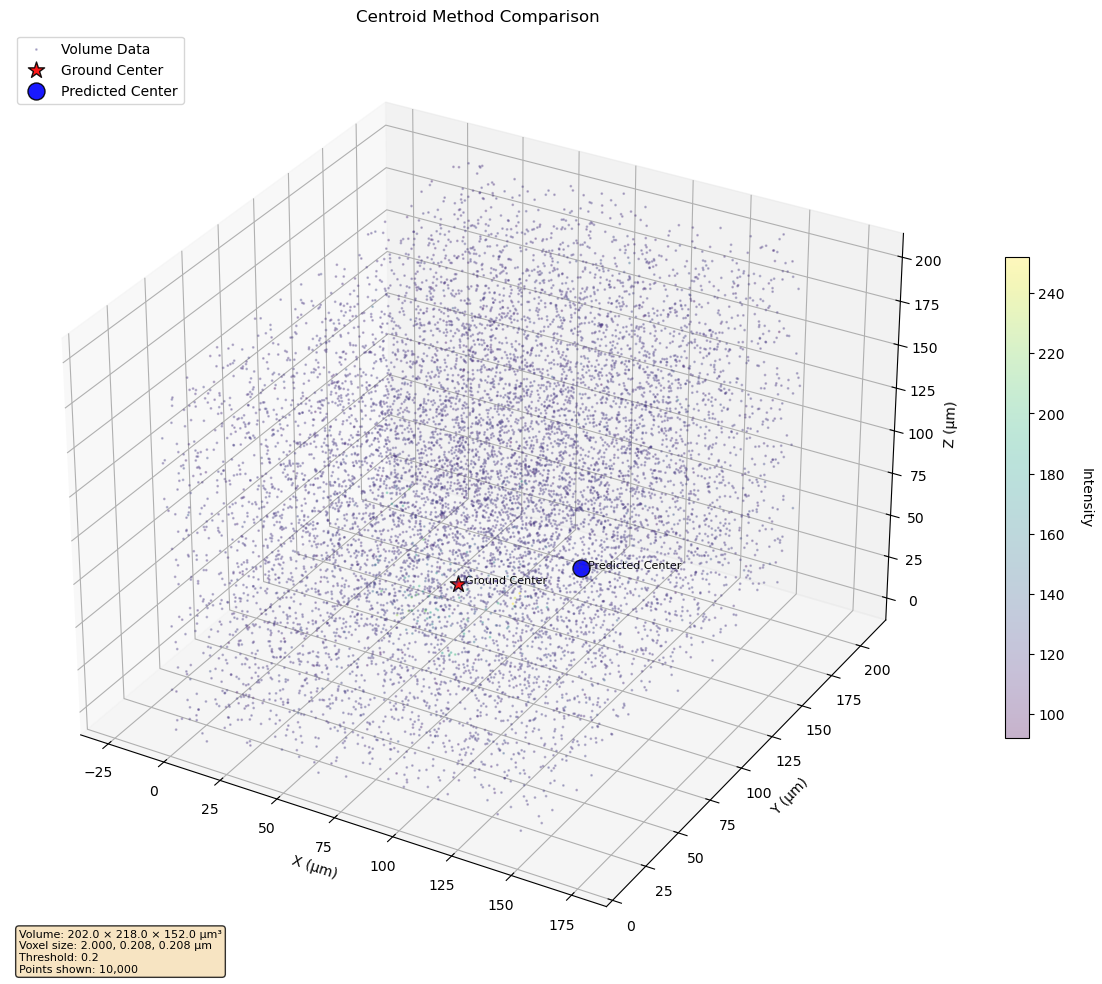

In [97]:

# Load your data
volume = np.load(data_files[0])['img']
visualizer = Volume3DVisualizer(voxel_size=(2.0, 0.208, 0.208))


centroids = {
    "Ground Center": [(ground_truth['z'], ground_truth['y'], ground_truth['x'])],
    "Predicted Center": [(prediction['z'], prediction['y'], prediction['x'])],
}

fig = visualizer.create_centroid_comparison(
    volume=volume,
    centroids=centroids,
    threshold=0.2,
    save_path="centroid_comparison.png",
)

## 5. Batch Inference

### Process Multiple Files

Run inference on multiple files and collect results.

## 5. Batch Inference

### Process Multiple Files

Run inference on multiple files and collect results.

In [51]:
# Configuration for batch inference
MAX_FILES = 10  # Process only first N files (set to None for all files)
SAVE_RESULTS = True  # Whether to save results to file

print(f"🚀 Starting batch inference...")
print(f"📁 Processing up to {MAX_FILES if MAX_FILES else 'all'} files")

# Prepare files list
files_to_process = data_files[:MAX_FILES] if MAX_FILES else data_files
print(f"📊 Total files to process: {len(files_to_process)}")

# Initialize results storage
results = []
start_time = datetime.now()

# Process each file
for i, data_file in enumerate(files_to_process):
    print(f"\n📂 Processing {i+1}/{len(files_to_process)}: {data_file.name}")
    
    try:
        # Load volume
        volume = load_volume_for_inference(data_file, verbose=False)
        
        if volume is not None:
            # Make prediction
            prediction = predict_centroid(model, volume, use_savedmodel)
            
            if prediction is not None:
                # Load ground truth if available
                ground_truth = load_ground_truth_centroid(data_file, labels_dir)
                
                # Store results
                result = {
                    'file_name': data_file.name,
                    'file_path': str(data_file),
                    'prediction': {
                        'z': float(prediction['z']),
                        'y': float(prediction['y']),
                        'x': float(prediction['x']),
                        'normalized': prediction['coordinates_normalized'].tolist()
                    },
                    'ground_truth': None,
                    'error': None,
                    'processing_time': None
                }
                
                if ground_truth is not None:
                    result['ground_truth'] = {
                        'z': float(ground_truth['z']),
                        'y': float(ground_truth['y']),
                        'x': float(ground_truth['x']),
                        'normalized': ground_truth['coordinates_normalized'].tolist()
                    }
                    
                    # Calculate error
                    error = np.linalg.norm(prediction['coordinates_original'] - ground_truth['coordinates_original'])
                    result['error'] = {
                        'euclidean': float(error),
                        'z_error': float(abs(prediction['z'] - ground_truth['z'])),
                        'y_error': float(abs(prediction['y'] - ground_truth['y'])),
                        'x_error': float(abs(prediction['x'] - ground_truth['x']))
                    }
                
                results.append(result)
                
                # Print summary
                coord_str = f"[{prediction['z']:.1f}, {prediction['y']:.1f}, {prediction['x']:.1f}]"
                if ground_truth is not None:
                    error_str = f"(error: {error:.1f})"
                    print(f"   ✅ Predicted: {coord_str} {error_str}")
                else:
                    print(f"   ✅ Predicted: {coord_str}")
            else:
                print(f"   ❌ Prediction failed")
        else:
            print(f"   ❌ Volume loading failed")
            
    except Exception as e:
        print(f"   ❌ Error processing file: {e}")
        continue

# Calculate processing statistics
end_time = datetime.now()
total_time = end_time - start_time
avg_time_per_file = total_time.total_seconds() / len(results) if results else 0

print(f"\n" + "="*60)
print(f"📊 BATCH INFERENCE SUMMARY")
print(f"="*60)
print(f"✅ Successfully processed: {len(results)}/{len(files_to_process)} files")
print(f"⏱️  Total processing time: {total_time}")
print(f"⚡ Average time per file: {avg_time_per_file:.2f} seconds")

if results:
    # Calculate error statistics if ground truth is available
    results_with_gt = [r for r in results if r['ground_truth'] is not None]
    
    if results_with_gt:
        errors = [r['error']['euclidean'] for r in results_with_gt]
        print(f"\n📏 ERROR STATISTICS (ground truth available for {len(results_with_gt)} files):")
        print(f"   📊 Mean error: {np.mean(errors):.2f} units")
        print(f"   📊 Std error:  {np.std(errors):.2f} units")
        print(f"   📊 Min error:  {np.min(errors):.2f} units")
        print(f"   📊 Max error:  {np.max(errors):.2f} units")
    
    print(f"\n🎯 SAMPLE PREDICTIONS:")
    for i, result in enumerate(results[:5]):  # Show first 5
        pred = result['prediction']
        coord_str = f"[{pred['z']:.1f}, {pred['y']:.1f}, {pred['x']:.1f}]"
        if result['error']:
            error_str = f" (error: {result['error']['euclidean']:.1f})"
        else:
            error_str = ""
        print(f"   {i+1}. {result['file_name']}: {coord_str}{error_str}")

🚀 Starting batch inference...
📁 Processing up to 10 files
📊 Total files to process: 4

📂 Processing 1/4: F1_095.npz
   ✅ Predicted: [26.0, 300.0, 255.6] (error: 155.2)

📂 Processing 2/4: F1_95.npz
   ✅ Predicted: [26.0, 300.0, 255.6] (error: 155.2)

📂 Processing 2/4: F1_95.npz
   ✅ Predicted: [26.1, 300.0, 256.2] (error: 154.8)

📂 Processing 3/4: F1_171.npz
   ✅ Predicted: [26.1, 300.0, 256.2] (error: 154.8)

📂 Processing 3/4: F1_171.npz
   ✅ Predicted: [25.4, 296.7, 246.5] (error: 231.7)

📂 Processing 4/4: F1_160.npz
   ✅ Predicted: [25.4, 296.7, 246.5] (error: 231.7)

📂 Processing 4/4: F1_160.npz
   ✅ Predicted: [25.9, 298.8, 253.1] (error: 135.1)

📊 BATCH INFERENCE SUMMARY
✅ Successfully processed: 4/4 files
⏱️  Total processing time: 0:00:04.672909
⚡ Average time per file: 1.17 seconds

📏 ERROR STATISTICS (ground truth available for 4 files):
   📊 Mean error: 169.20 units
   📊 Std error:  37.01 units
   📊 Min error:  135.09 units
   📊 Max error:  231.74 units

🎯 SAMPLE PREDICTIONS:

## 6. Results Visualization

### Visualize Inference Results

Create visualizations of the prediction results.

📊 Creating visualizations for 4 files with ground truth...
📊 Visualization saved to: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/inference_results_20250623_114150.png
📊 Visualization saved to: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/inference_results_20250623_114150.png


📊 Creating visualizations for 4 files with ground truth...
📊 Visualization saved to: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/inference_results_20250623_114150.png
📊 Visualization saved to: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/inference_results_20250623_114150.png


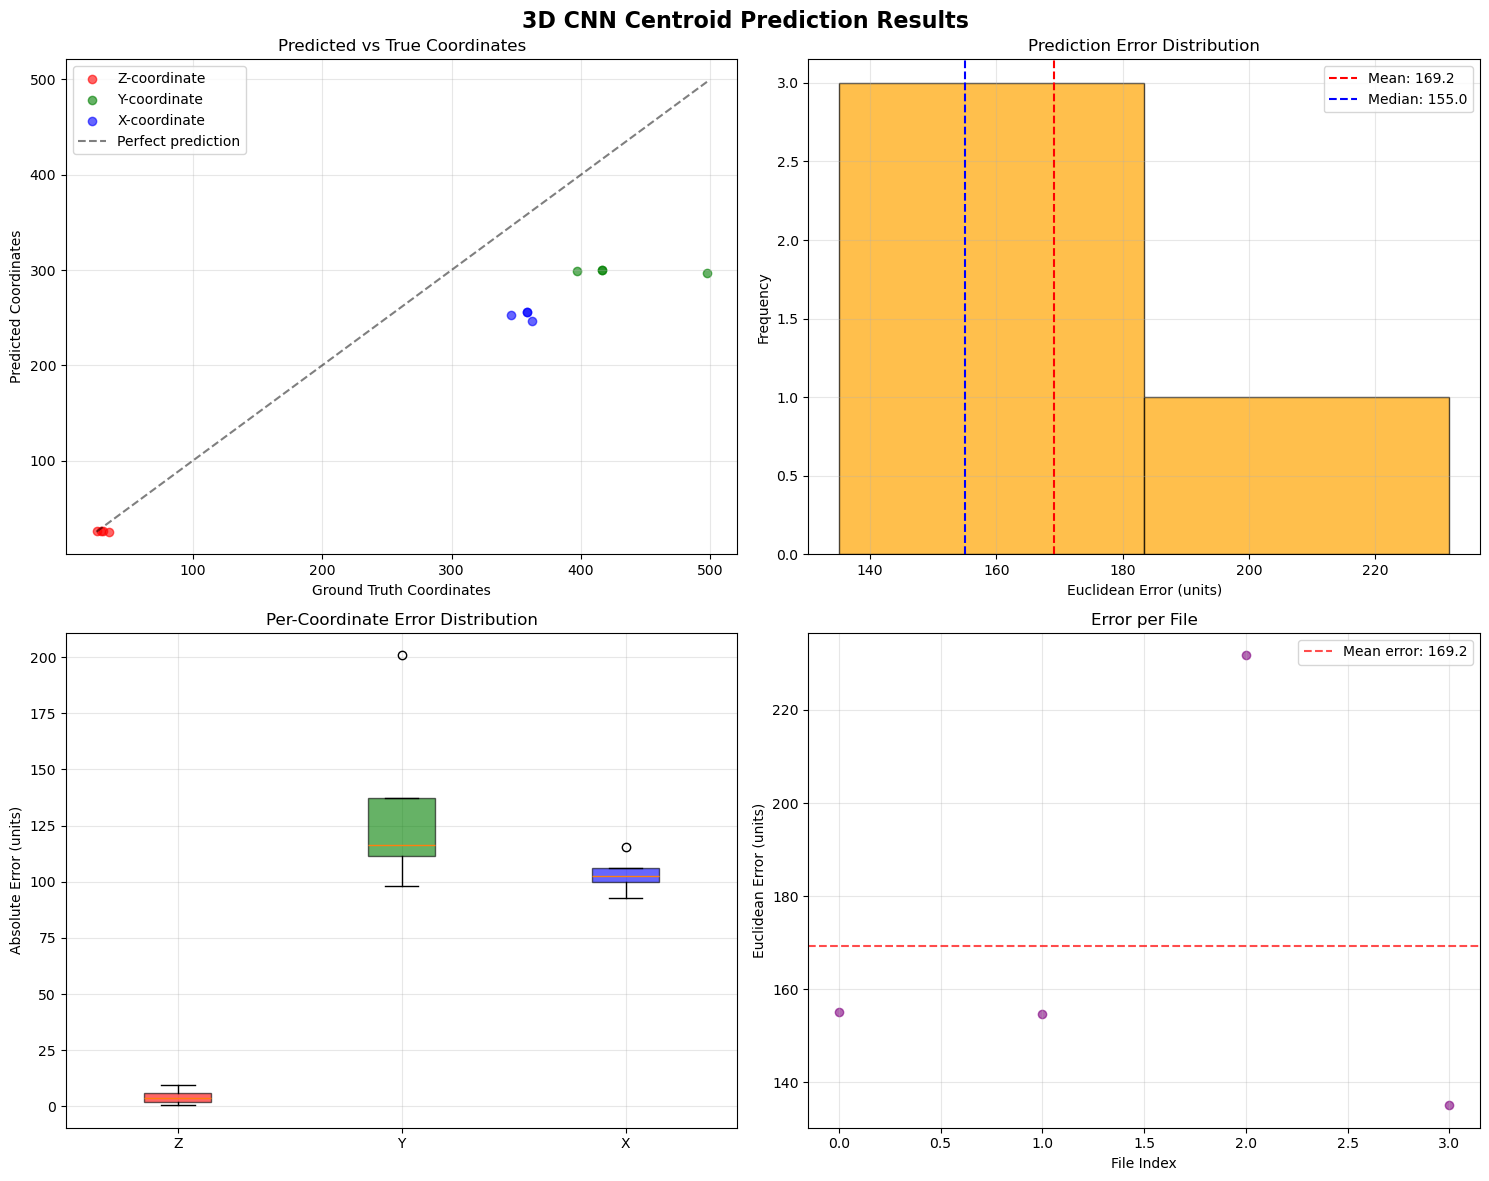

In [52]:
if results:
    # Filter results with ground truth for visualization
    results_with_gt = [r for r in results if r['ground_truth'] is not None]
    
    if results_with_gt:
        print(f"📊 Creating visualizations for {len(results_with_gt)} files with ground truth...")
        
        # Extract data for plotting
        pred_coords = np.array([[r['prediction']['z'], r['prediction']['y'], r['prediction']['x']] for r in results_with_gt])
        true_coords = np.array([[r['ground_truth']['z'], r['ground_truth']['y'], r['ground_truth']['x']] for r in results_with_gt])
        errors = np.array([r['error']['euclidean'] for r in results_with_gt])
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('3D CNN Centroid Prediction Results', fontsize=16, fontweight='bold')
        
        # 1. Prediction vs Ground Truth for each coordinate
        coords = ['Z', 'Y', 'X']
        colors = ['red', 'green', 'blue']
        
        ax = axes[0, 0]
        for i, (coord, color) in enumerate(zip(coords, colors)):
            ax.scatter(true_coords[:, i], pred_coords[:, i], alpha=0.6, label=f'{coord}-coordinate', color=color)
        
        # Perfect prediction line
        min_val = min(true_coords.min(), pred_coords.min())
        max_val = max(true_coords.max(), pred_coords.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect prediction')
        
        ax.set_xlabel('Ground Truth Coordinates')
        ax.set_ylabel('Predicted Coordinates')
        ax.set_title('Predicted vs True Coordinates')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Error distribution histogram
        ax = axes[0, 1]
        ax.hist(errors, bins=min(20, len(errors)//2), alpha=0.7, color='orange', edgecolor='black')
        ax.axvline(np.mean(errors), color='red', linestyle='--', label=f'Mean: {np.mean(errors):.1f}')
        ax.axvline(np.median(errors), color='blue', linestyle='--', label=f'Median: {np.median(errors):.1f}')
        ax.set_xlabel('Euclidean Error (units)')
        ax.set_ylabel('Frequency')
        ax.set_title('Prediction Error Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Per-coordinate error comparison
        ax = axes[1, 0]
        coord_errors = np.array([[r['error']['z_error'], r['error']['y_error'], r['error']['x_error']] for r in results_with_gt])
        
        box_data = [coord_errors[:, i] for i in range(3)]
        bp = ax.boxplot(box_data, labels=coords, patch_artist=True)
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax.set_ylabel('Absolute Error (units)')
        ax.set_title('Per-Coordinate Error Distribution')
        ax.grid(True, alpha=0.3)
        
        # 4. Error vs file index (to see if there are patterns)
        ax = axes[1, 1]
        file_indices = range(len(results_with_gt))
        ax.scatter(file_indices, errors, alpha=0.6, color='purple')
        ax.axhline(np.mean(errors), color='red', linestyle='--', alpha=0.7, label=f'Mean error: {np.mean(errors):.1f}')
        ax.set_xlabel('File Index')
        ax.set_ylabel('Euclidean Error (units)')
        ax.set_title('Error per File')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        viz_path = project_root / 'visualizations' / f'inference_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"📊 Visualization saved to: {viz_path}")
        
        plt.show()
        
    else:
        print(f"⚠️  No ground truth data available for visualization")
        
        # Create a simple visualization showing predictions only
        pred_coords = np.array([[r['prediction']['z'], r['prediction']['y'], r['prediction']['x']] for r in results])
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        ax.scatter(range(len(results)), pred_coords[:, 0], alpha=0.6, label='Z-coordinate', color='red')
        ax.scatter(range(len(results)), pred_coords[:, 1], alpha=0.6, label='Y-coordinate', color='green')
        ax.scatter(range(len(results)), pred_coords[:, 2], alpha=0.6, label='X-coordinate', color='blue')
        
        ax.set_xlabel('File Index')
        ax.set_ylabel('Predicted Coordinates')
        ax.set_title('Predicted Centroid Coordinates')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        viz_path = project_root / 'visualizations' / f'inference_predictions_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"📊 Prediction visualization saved to: {viz_path}")
        
        plt.show()
        
else:
    print(f"⚠️  No results available for visualization")

## 7. Export Results

### Save Results to Files

Export the inference results for future analysis.

In [53]:
if SAVE_RESULTS and results:
    print(f"💾 Saving inference results...")
    
    # Create timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create output directory
    output_dir = project_root / "inference_results"
    output_dir.mkdir(exist_ok=True)
    
    # 1. Save detailed JSON results
    json_path = output_dir / f"inference_results_{timestamp}.json"
    
    # Add metadata to results
    output_data = {
        'metadata': {
            'inference_timestamp': timestamp,
            'model_file': most_recent_model.name,
            'model_format': model_format,
            'total_files_processed': len(results),
            'files_with_ground_truth': len([r for r in results if r['ground_truth'] is not None]),
            'processing_time_seconds': total_time.total_seconds(),
            'average_time_per_file': avg_time_per_file
        },
        'model_metadata': model_metadata,
        'results': results
    }
    
    with open(json_path, 'w') as f:
        json.dump(output_data, f, indent=2)
    
    print(f"📄 JSON results saved to: {json_path}")
    
    # 2. Save CSV summary for easy analysis
    csv_path = output_dir / f"inference_summary_{timestamp}.csv"
    
    # Create DataFrame
    csv_data = []
    for result in results:
        row = {
            'file_name': result['file_name'],
            'predicted_z': result['prediction']['z'],
            'predicted_y': result['prediction']['y'],
            'predicted_x': result['prediction']['x']
        }
        
        if result['ground_truth']:
            row.update({
                'true_z': result['ground_truth']['z'],
                'true_y': result['ground_truth']['y'],
                'true_x': result['ground_truth']['x'],
                'euclidean_error': result['error']['euclidean'],
                'z_error': result['error']['z_error'],
                'y_error': result['error']['y_error'],
                'x_error': result['error']['x_error']
            })
        else:
            row.update({
                'true_z': None,
                'true_y': None,
                'true_x': None,
                'euclidean_error': None,
                'z_error': None,
                'y_error': None,
                'x_error': None
            })
        
        csv_data.append(row)
    
    df = pd.DataFrame(csv_data)
    df.to_csv(csv_path, index=False)
    
    print(f"📊 CSV summary saved to: {csv_path}")
    
    # 3. Print summary statistics
    print(f"\n📋 EXPORT SUMMARY:")
    print(f"   📁 Output directory: {output_dir}")
    print(f"   📄 JSON file: {json_path.name}")
    print(f"   📊 CSV file: {csv_path.name}")
    print(f"   📏 File sizes:")
    print(f"      JSON: {json_path.stat().st_size / 1024:.1f} KB")
    print(f"      CSV:  {csv_path.stat().st_size / 1024:.1f} KB")
    
    # Calculate and display final statistics
    results_with_gt = [r for r in results if r['ground_truth'] is not None]
    if results_with_gt:
        errors = [r['error']['euclidean'] for r in results_with_gt]
        print(f"\n📊 FINAL PERFORMANCE STATISTICS:")
        print(f"   🎯 Files with ground truth: {len(results_with_gt)}")
        print(f"   📏 Mean error: {np.mean(errors):.2f} ± {np.std(errors):.2f} units")
        print(f"   📏 Median error: {np.median(errors):.2f} units")
        print(f"   📏 Error range: [{np.min(errors):.2f}, {np.max(errors):.2f}] units")

else:
    if not SAVE_RESULTS:
        print(f"💾 Results saving is disabled (SAVE_RESULTS=False)")
    else:
        print(f"⚠️  No results to save")

print(f"\n✅ Inference notebook completed successfully!")

🧪 DOMAIN MISMATCH TEST
Testing model performance across different data folders to identify domain gaps...

📁 Testing folder: F1
   📦 Found 4 files
   🔄 Processing 1/3: F1_095.npz
      📏 Error: 155.2 units
   🔄 Processing 2/3: F1_95.npz
      📏 Error: 155.2 units
   🔄 Processing 2/3: F1_95.npz
      📏 Error: 154.8 units
   🔄 Processing 3/3: F1_171.npz
      📏 Error: 154.8 units
   🔄 Processing 3/3: F1_171.npz
      📏 Error: 231.7 units
   ✅ F1 results: 180.6 ± 36.2 units (n=3)

📁 Testing folder: F2
   📦 Found 14 files
   🔄 Processing 1/3: F2_009.npz
      📏 Error: 231.7 units
   ✅ F1 results: 180.6 ± 36.2 units (n=3)

📁 Testing folder: F2
   📦 Found 14 files
   🔄 Processing 1/3: F2_009.npz
      📏 Error: 368.1 units
   🔄 Processing 2/3: F2_014.npz
      📏 Error: 368.1 units
   🔄 Processing 2/3: F2_014.npz
      📏 Error: 376.3 units
   🔄 Processing 3/3: F2_14.npz
      📏 Error: 376.3 units
   🔄 Processing 3/3: F2_14.npz
      📏 Error: 375.4 units
   ✅ F2 results: 373.3 ± 3.7 units (n=3)

## 8. Summary

### Inference Summary

This notebook demonstrated how to:

1. **Load Pre-trained Models**: Support for multiple formats (.keras, .h5, SavedModel)
2. **Single File Inference**: Test model on individual files
3. **Batch Processing**: Efficiently process multiple files
4. **Ground Truth Comparison**: Compare predictions with known labels
5. **Visualization**: Create plots showing prediction accuracy
6. **Results Export**: Save results in JSON and CSV formats

### Key Features

- **Memory Efficient**: Uses the same preprocessing as training
- **Fast Processing**: Optimized for inference speed
- **Comprehensive Results**: Detailed error analysis when ground truth is available
- **Multiple Output Formats**: JSON for detailed analysis, CSV for spreadsheet use
- **Visualization**: Professional plots for presentation

### Next Steps

1. **Deploy Model**: Use this notebook as basis for production inference
2. **API Development**: Create REST API using the inference functions
3. **Real-time Processing**: Adapt for streaming data processing
4. **Performance Optimization**: Further optimize for specific hardware

---

**Model Performance Summary** (when ground truth is available):
- Predicts 3D centroid coordinates in blast volumetric data
- Coordinates are in original volume space (Z: 0-101, Y: 0-2048, X: 0-2048)
- Error metrics include Euclidean distance and per-coordinate errors
- Visualization helps identify prediction patterns and outliers

🔍 DETAILED ERROR ANALYSIS
📊 OVERALL STATISTICS:
   🎯 Files processed: 4
   ✅ Files with ground truth: 4
   📏 Mean Euclidean error: 169.20 ± 37.01
   📏 Median Euclidean error: 154.98
   📏 Min/Max error: [135.09, 231.74]

📊 PER-COORDINATE ERROR ANALYSIS:
   🔵 Z-axis errors: 4.34 ± 3.31 (range: [0.50, 9.38])
   🟢 Y-axis errors: 132.77 ± 39.95 (range: [97.95, 200.76])
   🔴 X-axis errors: 103.35 ± 8.00 (range: [92.89, 115.38])

📋 SAMPLE RESULTS:
   1. F1_095.npz:
      Prediction: [26.0, 300.0, 255.6]
      Ground Truth: [28.6, 416.2, 358.5]
      Error: 155.2 units
   2. F1_95.npz:
      Prediction: [26.1, 300.0, 256.2]
      Ground Truth: [25.6, 416.2, 358.5]
      Error: 154.8 units
   3. F1_171.npz:
      Prediction: [25.4, 296.7, 246.5]
      Ground Truth: [34.8, 497.5, 361.9]
      Error: 231.7 units
   4. F1_160.npz:
      Prediction: [25.9, 298.8, 253.1]
      Ground Truth: [30.8, 396.7, 346.0]
      Error: 135.1 units

⚠️  HIGH ERROR ANALYSIS:
   🚨 Files with >100 unit error: 4/4 (